# Clasificador Binario

## Librerías

In [36]:
!pip install fastai -Uq
!pip install timm -q


#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

     |████████████████████████████████| 431 kB 14.6 MB/s 


{'restart': True, 'status': 'ok'}

In [1]:
!pip install wwf -q

In [2]:
from fastai.vision.all import *

#Estas liberías son para las arquitectuas EffiecientNet e Inception
import timm
from wwf.utils import *
from wwf.vision.timm import *

## Dataset

En este caso estamos usando el dataset que ha sido preprocesados mediante el método de recorte

In [2]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

2022-06-18 16:18:29 URL:https://uc37869bcfc4277555d995a63518.dl.dropboxusercontent.com/cd/0/inline2/BnfB_0D2Ac3RPdCITIt_YUyB2d-CiGpXzKc10kRKlfRXM_LNQPCAzxPRwvq3VPzJ8KZ46tO3A4apcq67vN1pU01o8bCk4YzwWR0i4p75YwjF9ubr9lJANud0ivdS1ogJ-33-d10d6epbv97XvZ0Fh8dXTrMfkv62F5BFM1i64Ea-6xLqUgSyOpVQfJh5ObK3bC66pkSRfGDw2DIfWpaLtqMqcxlvQOob09BlenxWogdhtONGLAYNbxBGCVuRQW1f5M4YKvILarCtfAwtAWm2Mpoe5SGcxLIzsguIauKAEingbod661g2F5RACuWUmJlWS3jNm2B5ZdLnXYH3gqFQjAvZ-XGq6Ukz9xnEEApJurQQ-OTO2Lubt-wKR6ECe9_D2ZA1kIRaGxy3t3VWyVyJ0tW6Ecfu6tjd97yR4ZImSBlo4A/file [138777773/138777773] -> "train.zip" [1]
2022-06-18 16:18:33 URL:https://ucad6c40aac5c3c149b134c8a960.dl.dropboxusercontent.com/cd/0/inline2/Bnc0neiThRCtHuFXQPoT0zIVTAFbcfR5AXHWdrk8vEN4s-q96Ke1n0XmSAPxzSb_QQNPjhCJofYMs2FtAVaHRV5wHSS5FFeqmIUHufgl9vAwxaOdupxVHC69gzi3OhI0ZwySCQQJuyx28PCCHrf9nG7FoNTQHP8JBuQ_HLwOfHk-cciimWAxlK8AgW6X5ecpTk_QQdaJjKpj4mgM9MGNKb5WbFQm0WgJCD8oayeAGT_kNB-jNjERc4n1t6GB8AuSLjPYv-moGUlYM2aZInEVcSOvlNxZI8B-kjgnL_8GWDoo-Pp5tIiU817vIDpifxLfx1x

In [3]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

Tenemos que cambiar la estructura del dataset


```.
└── dataset
    ├── train
    │   ├── normal
    │   └── enfermedad
    ├── test
    │   ├── normal
    │   └── enfermedad
    └── validation
        ├── normal
        └── enfermedad
```

Para ello usaremos el archivo csv de cada conjunto para mover cada imagen a donde corresponda

In [4]:
#Método para crear estructura de directorios
def crearEstructura(nombreDataset, clases):
  !mkdir "$nombreDataset"
  !mkdir "$nombreDataset"/test
  !mkdir "$nombreDataset"/train
  !mkdir "$nombreDataset"/val
  for x in clases:
    !mkdir "$nombreDataset"/train/"$x"
    !mkdir "$nombreDataset"/test/"$x"
    !mkdir "$nombreDataset"/val/"$x"

In [5]:
crearEstructura('dataset', ['normal', 'enfermedad'])

Creamos un path que apunte a la carpeta donde vamos a tener el dataset estructurado posteriormente:

In [5]:
path = Path('dataset/')

In [6]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [7]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

In [9]:
#1519 tienen enfermedad y 401 no la tienen
df_train['Disease_Risk'].value_counts()

1    1519
0     401
Name: Disease_Risk, dtype: int64

In [10]:
df_val['Disease_Risk'].value_counts() #506 - 134
df_test['Disease_Risk'].value_counts()

1    506
0    134
Name: Disease_Risk, dtype: int64

Una vez creada la estructura mencionada antes movemos las imágenes a la carpeta que corresponda. Repetimos esto para los tres conjuntos.

In [11]:
import shutil

def moverImg(df, pathO, pathD):
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    if(int(enf)==0):
        shutil.move(pathO + '/' + str(id) + '.png', pathD + '/normal')
    else:
        shutil.move(pathO + str(id) + '.png', pathD + '/enfermedad')

In [12]:
moverImg(df_train, str(trainPath) + '/Training/', str(path)  + '/train')
moverImg(df_test, str(testPath) + '/Test/', str(path)  + '/test')
moverImg(df_val, str(valPath) + '/Validation/', str(path)  + '/val')

In [13]:
len(Path(trainPath/'Training').ls()) #1921
len(Path(testPath/'Test').ls())      #640
len(Path(valPath/'Validation').ls()) #640

0

In [8]:
len(Path('dataset/train/normal').ls()) #401

401

Ahora que ya tenemos la estructura deseado empezamos a construir el modelo:

## Cargando el dataset

In [9]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))

In [10]:
dls = db.dataloaders(path,bs=128)

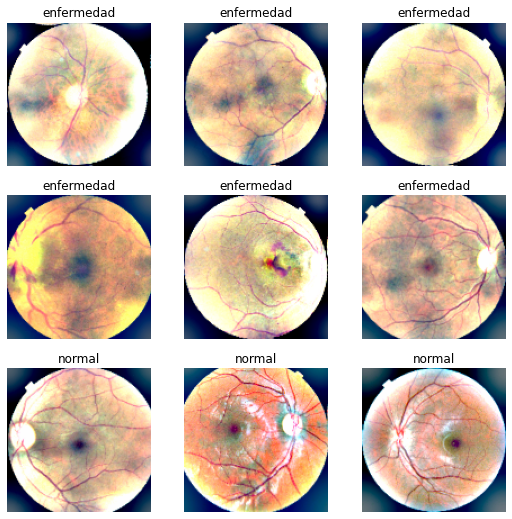

In [11]:
dls.show_batch()

In [3]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=20),
    SaveModelCallback()
]

In [12]:
metrics=[ accuracy, Precision(), Recall(), F1Score(), error_rate ]
learn = timm_learner(dls, 'efficientnet_b3', metrics=metrics, cbs=callbacks)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_ra2-cf984f9c.pth


SuggestedLRs(minimum=0.00831763744354248, steep=1.0964781722577754e-06, valley=0.0006918309954926372, slide=0.005248074419796467)

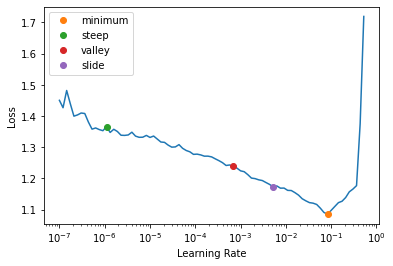

In [13]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

## Entrenamos el modelo

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,error_rate,time
0,1.286890,0.926694,0.462500,0.216216,0.597015,0.317460,0.537500,00:12


Better model found at epoch 0 with valid_loss value: 0.9266940951347351.


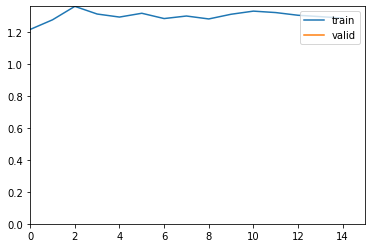

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,error_rate,time
0,1.315159,0.951010,0.485938,0.231405,0.626866,0.338028,0.514063,00:14
1,1.252878,0.916529,0.510938,0.235988,0.597015,0.338266,0.489062,00:12
2,1.253583,0.863308,0.528125,0.251479,0.634328,0.360169,0.471875,00:12
3,1.239983,0.872114,0.520312,0.246334,0.626866,0.353684,0.479688,00:14
4,1.279450,0.862005,0.526563,0.253644,0.649254,0.364780,0.473437,00:14
5,1.252932,0.884945,0.540625,0.264706,0.671642,0.379747,0.459375,00:12
6,1.252865,0.853657,0.539062,0.262537,0.664179,0.376321,0.460938,00:13
7,1.255003,0.847430,0.545313,0.265672,0.664179,0.379531,0.454688,00:12
8,1.259161,0.825122,0.556250,0.274096,0.679104,0.390558,0.443750,00:12
9,1.253018,0.819393,0.553125,0.269697,0.664179,0.383621,0.446875,00:12


Better model found at epoch 0 with valid_loss value: 0.9510104060173035.


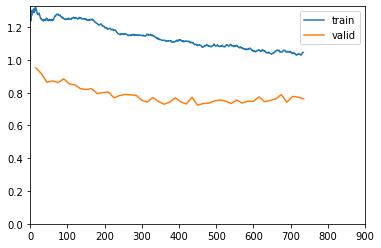

Better model found at epoch 1 with valid_loss value: 0.9165292978286743.
Better model found at epoch 2 with valid_loss value: 0.863308310508728.
Better model found at epoch 4 with valid_loss value: 0.862005352973938.
Better model found at epoch 6 with valid_loss value: 0.8536574244499207.
Better model found at epoch 7 with valid_loss value: 0.8474297523498535.
Better model found at epoch 8 with valid_loss value: 0.8251221776008606.
Better model found at epoch 9 with valid_loss value: 0.8193925023078918.
Better model found at epoch 11 with valid_loss value: 0.7949260473251343.
Better model found at epoch 14 with valid_loss value: 0.7694231867790222.
Better model found at epoch 19 with valid_loss value: 0.7534269690513611.
Better model found at epoch 20 with valid_loss value: 0.7438247203826904.
Better model found at epoch 23 with valid_loss value: 0.7297009825706482.
Better model found at epoch 29 with valid_loss value: 0.7234675288200378.
No improvement since epoch 29: early stopping
C

In [14]:
%%time
learn.fine_tune(60,base_lr=1e-5)

Exportamos el modelo

In [15]:
learn.to_fp32()
learn.export('Binario_CEL_efficientnet_b3.pkl')

## Evaluando el modelo

In [16]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))
dlsTest = dbTest.dataloaders(path,bs=128)

In [17]:
learn.dls = dlsTest

In [18]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6328125.


(#6) [0.7746881246566772,0.6328125,0.3396825396825397,0.7985074626865671,0.4766146993318485,0.3671875]

## Interpretación del modelo

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


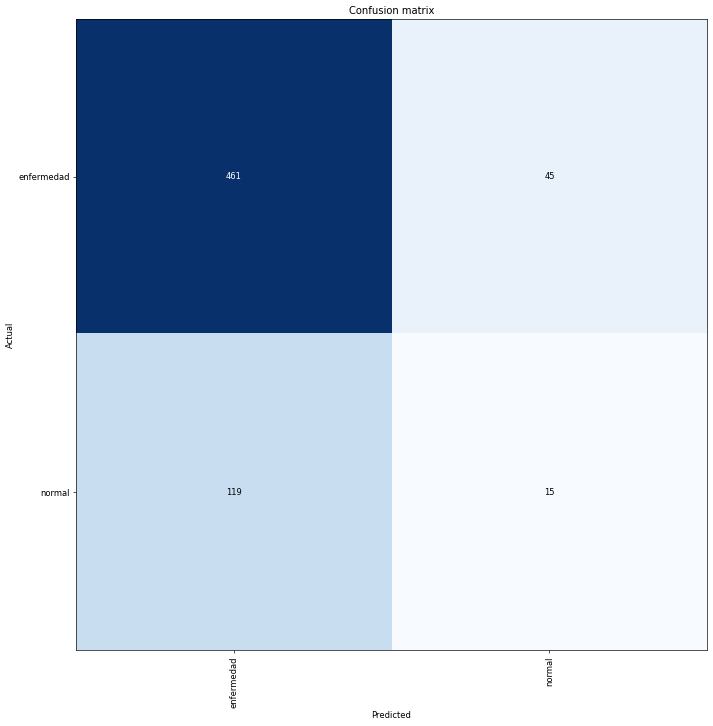

In [19]:
learn_inf = load_learner('Binario_CEL_efficientnet_b3.pkl')
learnInterp = cnn_learner(dls,resnet18).to_fp16()
learnInterp.model = learn_inf.model
interp = ClassificationInterpretation.from_learner(learnInterp)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)